# 머지된 LoRA 모델 S3 로 업로드


In [ ]:
!pip install -q torch==2.1.0 transformers>=4.25.1 accelerate>=0.22.0 peft==0.7.0 diffusers>=0.27.2 xformers --extra-index-url=https://download.pytorch.org/whl/cu118

In [1]:
import boto3
import torch
import sagemaker
from diffusers import DiffusionPipeline, AutoencoderKL, LCMScheduler
from diffusers.utils import load_image, make_image_grid

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
cache_dir = "/home/ec2-user/SageMaker/.cache"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 테스트


In [3]:
model_id = "./fused"
vae_id = "madebyollin/sdxl-vae-fp16-fix"

In [4]:
vae = AutoencoderKL.from_pretrained(vae_id, torch_dtype=torch.float16)

pipe = DiffusionPipeline.from_pretrained(
    model_id,
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    cache_dir=cache_dir,
)
pipe.enable_xformers_memory_efficient_attention()

pipe.to(device=device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "./fused",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

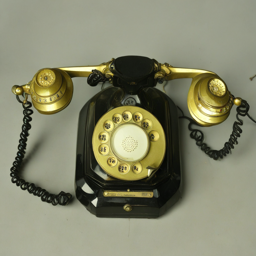

In [5]:
img = pipe(
    prompt='a telephone',
    negative_prompt='hand, watermark',
    num_inference_steps=50,
    guidance_scale=7.5,
).images[0]
img.resize((256, 256))

  0%|          | 0/50 [00:00<?, ?it/s]

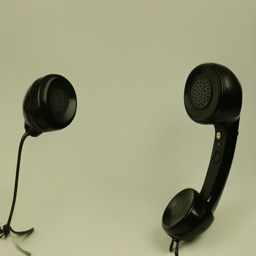

In [6]:
img = pipe(
    prompt='a telephone handset',
    negative_prompt='cord, hand, watermark',
    num_inference_steps=50,
    guidance_scale=7.5,
).images[0]
img.resize((256, 256))

# 모델 파일 생성


In [1]:
%cd ./fused

/home/ec2-user/SageMaker/hyundai/packages/notebooks/merge-lora/fused


In [2]:
!tar zcvf model.tar.gz .

./
./text_encoder_2/
./text_encoder_2/config.json
./text_encoder_2/model.safetensors
./vae/
./vae/config.json
./vae/diffusion_pytorch_model.safetensors
./model_index.json
./scheduler/
./scheduler/.ipynb_checkpoints/
./scheduler/.ipynb_checkpoints/scheduler_config-checkpoint.json
./scheduler/scheduler_config.json
./tokenizer/
./tokenizer/special_tokens_map.json
./tokenizer/vocab.json
./tokenizer/tokenizer_config.json
./tokenizer/merges.txt
./unet/
./unet/config.json
./unet/diffusion_pytorch_model.safetensors
./tokenizer_2/
./tokenizer_2/special_tokens_map.json
./tokenizer_2/vocab.json
./tokenizer_2/tokenizer_config.json
./tokenizer_2/merges.txt
./text_encoder/
./text_encoder/config.json
./text_encoder/model.safetensors
tar: .: file changed as we read it


# 모델 업로드


In [6]:
try:
    aws_role = sagemaker.get_execution_role()
except:
    iam = boto3.client("iam")
    # TODO: replace with your role name (i.e. "AmazonSageMaker-ExecutionRole-20211014T154824")
    aws_role = iam.get_role(RoleName="<replace with your RoleName>")["Role"]["Arn"]

boto_session = boto3.Session()
aws_region = boto_session.region_name
sess = sagemaker.Session(boto_session=boto_session)
account_id = boto3.client("sts").get_caller_identity().get("Account")

print(aws_role)
print(aws_region)
print(sess.boto_region_name)

arn:aws:iam::851725450449:role/service-role/AmazonSageMaker-ExecutionRole-20240125T135936
us-east-1
us-east-1


In [13]:
output_bucket = sess.default_bucket()
output_prefix = "sdxl-txt2img-lora"

s3_fused_output_location = f"s3://{output_bucket}/{output_prefix}/fused/model.tar.gz"
s3_fused_output_location

's3://sagemaker-us-east-1-851725450449/sdxl-txt2img-lora/fused/model.tar.gz'

In [14]:
!pwd

/home/ec2-user/SageMaker/hyundai/packages/notebooks/merge-lora/fused


In [15]:
!aws s3 cp model.tar.gz $s3_fused_output_location

upload: ./model.tar.gz to s3://sagemaker-us-east-1-851725450449/sdxl-txt2img-lora/fused/model.tar.gz


$s3_fused_output_location 를 train_model_uri 로 사용하여 모델을 추가 파인튜닝
